<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Watson Machine Learning - Quality Monitor and Feedback Logging

### Contents

- [1.0 Install Python Packages](#setup)
- [2.0 Configure Credentials](#credentials)
- [3.0 OpenScale configuration](#openscale)
- [4.0 Get Subscriptions](#subscription)
- [5.0 Quality monitoring and Feedback logging](#quality)

# 1.0 Install Python Packages

In [1]:
!rm -rf /home/spark/shared/user-libs/python3.6*

!pip install --upgrade ibm-ai-openscale==2.2.1 --no-cache | tail -n 1
!pip install --upgrade watson-machine-learning-client-V4==1.0.55 | tail -n 1
!pip install --upgrade pyspark==2.3 | tail -n 1

### Action: restart the kernel!

# 2.0 Configure credentials <a name="credentials"></a>



In [2]:
import warnings
warnings.filterwarnings('ignore')

The url for `WOS_CREDENTIALS` is the url of the CP4D cluster, i.e. `https://zen-cpd-zen.apps.com`. `username` and `password` must be ones that have cluster admin privileges.

In [3]:
WOS_CREDENTIALS = {
    "url": "https://zen-cpd-zen.omid-cp4d-v5-2bef1f4b4097001da9502000c44fc2b2-0001.us-south.containers.appdomain.cloud",
    "username": "*****",
    "password": "*****"
}

In [4]:
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='2.5.0'

In [5]:
%store -r MODEL_NAME
%store -r DEPLOYMENT_NAME
%store -r DEFAULT_SPACE

# 3.0 Configure OpenScale <a name="openscale"></a>

The notebook will now import the necessary libraries and configure OpenScale

In [6]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

In [7]:
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

In [9]:
ai_client = APIClient4ICP(WOS_CREDENTIALS)
ai_client.version

'2.2.1'

# 4.0 Get Subscription <a name="subscription"></a>

In [10]:
subscription = None

if subscription is None:
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            print("Found existing subscription.")
            subscription = ai_client.data_mart.subscriptions.get(sub)
if subscription is None:
    print("No subscription found. Please run openscale-initial-setup.ipynb to configure.")

Found existing subscription.


### Set Deployment UID

In [11]:
wml_client.set.default_space(DEFAULT_SPACE)

'SUCCESS'

In [12]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    print(deployment['entity']['name'])
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break
        
print(deployment_uid)

sda-deployment-6-17-2020
8d1e7718-a378-422e-83f0-3bcbcc2baf34


# 5.0 Quality monitoring and Feedback logging
 <a name="quality"></a>

## 4.1 Enable quality monitoring

The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality (accuracy) monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [13]:
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

## 4.2 Feedback logging

The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [14]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/IBM/monitor-ibm-cloud-pak-with-watson-openscale/master/data/additional_feedback_data.json


rm: cannot remove 'additional_feedback_data.json': No such file or directory
--2020-06-23 22:27:46--  https://raw.githubusercontent.com/IBM/monitor-ibm-cloud-pak-with-watson-openscale/master/data/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: 'additional_feedback_data.json'

100%[======================================>] 16,506      --.-K/s   in 0.001s  

2020-06-23 22:27:46 (16.0 MB/s) - 'additional_feedback_data.json' saved [16506/16506]



In [15]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
subscription.feedback_logging.store(additional_feedback_data['data'])

In [16]:
subscription.feedback_logging.show_table()

less_0,10,all_credits_paid_back,car_new,250,500_to_1000,4_to_7,3,male,none,2,real_estate,23,none,rent,1,skilled,1,none,yes,No Risk,2020-06-23 22:27:50.306882+00:00
no_checking,23,prior_payments_delayed,appliances,6964,100_to_500,4_to_7,4,female,none,3,car_other,39,none,own,1,skilled,1,none,yes,Risk,2020-06-23 22:27:50.307055+00:00
0_to_200,30,outstanding_credit,appliances,3464,100_to_500,greater_7,3,male,guarantor,4,savings_insurance,51,stores,free,1,skilled,1,yes,yes,Risk,2020-06-23 22:27:50.307106+00:00
no_checking,23,outstanding_credit,car_used,2681,500_to_1000,greater_7,4,male,none,3,car_other,33,stores,free,1,unskilled,1,yes,yes,No Risk,2020-06-23 22:27:50.307145+00:00
0_to_200,18,prior_payments_delayed,furniture,1673,less_100,1_to_4,2,male,none,3,car_other,30,none,own,2,skilled,1,none,yes,Risk,2020-06-23 22:27:50.307182+00:00
no_checking,44,outstanding_credit,radio_tv,3476,unknown,greater_7,4,male,co-applicant,4,unknown,60,none,free,2,skilled,2,yes,yes,Risk,2020-06-23 22:27:50.307218+00:00
less_0,8,no_credits,education,803,less_100,unemployed,1,male,none,1,savings_insurance,19,stores,rent,1,skilled,1,none,yes,No Risk,2020-06-23 22:27:50.307253+00:00
0_to_200,7,all_credits_paid_back,car_new,250,less_100,unemployed,1,male,none,1,real_estate,19,stores,rent,1,skilled,1,none,yes,No Risk,2020-06-23 22:27:50.307314+00:00
0_to_200,33,credits_paid_to_date,radio_tv,3548,100_to_500,1_to_4,3,male,none,4,car_other,28,none,own,2,skilled,1,yes,yes,Risk,2020-06-23 22:27:50.307351+00:00
no_checking,24,prior_payments_delayed,retraining,4158,100_to_500,greater_7,3,female,none,2,savings_insurance,35,stores,own,1,unskilled,2,none,yes,Risk,2020-06-23 22:27:50.307387+00:00


In [17]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 97c61aa0-338a-4d30-b8c7-16bcb12f317f 




completed

---------------------------
 Successfully finished run 
---------------------------




In [18]:
subscription.quality_monitoring.show_table()

2020-06-23 22:29:36.014000+00:00,true_positive_rate,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.36363636363636365,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,area_under_roc,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.6510489510489511,0.7,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,precision,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.75,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,f1_measure,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.48979591836734687,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,accuracy,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.7448979591836735,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,log_loss,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.44438227650606726,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,false_positive_rate,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.06153846153846154,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,area_under_pr,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.6185064935064934,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34
2020-06-23 22:29:36.014000+00:00,recall,9f4e870b-43d1-43be-bf11-488946eb4f2e,0.36363636363636365,,,model_type: original,999,3ac0127b-fe13-4b18-9785-9aed3f211d97,8d1e7718-a378-422e-83f0-3bcbcc2baf34


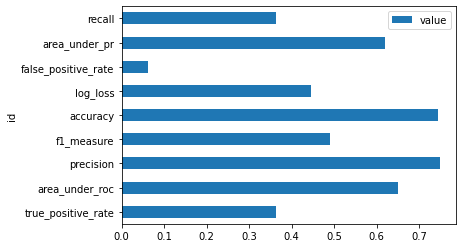

In [19]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

In [20]:
ai_client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': '67158df7-b383-4353-a5be-cd5980276c04',
    'asset_type': 'model',
    'created_at': '2020-04-14T20:32:38.002Z',
    'name': 'GermanCreditRiskModelICP',
    'url': 'https://ibm-nginx-svc.zen.svc.cluster.local/v4/models/67158df7-b383-4353-a5be-cd5980276c04?space_id=ddd46f03-134f-4345-bc7d-cf94dff459a2'},
   'deployment': {'created_at': '2020-04-14T20:32:43.331Z',
    'deployment_id': '680cef07-0535-4861-ae0b-0dbb3fd905dc',
    'deployment_rn': '',
    'deployment_type': 'online',
    'name': 'GermanCreditRiskModelICP',
    'scoring_endpoint': {'request_headers': {'Content-Type': 'application/json'},
     'url': 'https://ibm-nginx-svc.zen.svc.cluster.local/v4/deployments/680cef07-0535-4861-ae0b-0dbb3fd905dc/predictions'},
    'url': 'https://ibm-nginx-svc.zen.svc.cluster.local/v4/deployments/680cef07-0535-4861-ae0b-0dbb3fd905dc'},
   'metrics': [{'issues': 0,
     'metric_type': 'performance',
     'timestamp': '2020-04-14T19:37:22Z',
     '

## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now view the OpenScale dashboard by going to the CPD `Home` page, and clicking `Services`. Choose the `OpenScale` tile and click the menu to `Open`. Click on the tile for the model you've created to see Quality monitor. Click on the timeseries graph to get detailed information on transactions during a specific time window.

OpenScale shows model performance over time. You have two options to keep data flowing to your OpenScale graphs:
  * Download, configure and schedule the [model feed notebook](https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_scoring_feed.ipynb). This notebook can be set up with your WML credentials, and scheduled to provide a consistent flow of scoring requests to your model, which will appear in your OpenScale monitors.
  * Re-run this notebook. Running this notebook from the beginning will delete and re-create the model and deployment, and re-create the historical data. Please note that the payload and measurement logs for the previous deployment will continue to be stored in your datamart, and can be deleted if necessary.

## Authors

Eric Martens, is a technical specialist having expertise in analysis and description of business processes, and their translation into functional and non-functional IT requirements. He acts as the interpreter between the worlds of IT and business.

Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Zilu (Peter) Tang, is a cognitive developer with experties in deep learning and enterprise AI solutions from Watson Openscale to many other cutting-edge IBM research projects.